# TODO
1. PairPlots
2. Profiling reports
3. Compare results to preprocessed of UCI

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [5]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [6]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = re.sub("[a-zA-Z]+ ","name\n", dataString)
        dataString = dataString.replace(" ",",")
        return dataString

In [7]:
# read the data from the specified datasets into the df
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [8]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [9]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

In [10]:
df = df.replace(-9, float('nan'))

In [11]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name", # Constant

]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [12]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
    'junk'
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [13]:
hidden_identifier = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(hidden_identifier, inplace=True, axis=1)

# Start of analysis
## see effects of enriching smoke

In [14]:
#enrich smoke
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
percentage_missing_pre = ((df["smoke"].isna().sum() / len(df) * 100).round(2))

dfst = DataframeSmokeTransformer()
df = dfst.transform(df)

percentage_missing_post = ((df["smoke"].isna().sum() / len(df) * 100).round(2))
print(f"missing before enrichment:\t {percentage_missing_pre}%")
print(f"missing after enrichment:\t {percentage_missing_post}%")

missing before enrichment:	 74.42%
missing after enrichment:	 43.05%


## Explore how many NaNs and zeros are within one column for each attribute.

In [15]:
(df.loc[:, df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,91,0,0,0,0,0,108,0,115,115,115,240,0,107,138,271,186,211,252,248,0,0,43,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,157,0
hungarian,0,81,23,164,141,0,0,195,0,10,0,0,266,0,1,235,293,274,265,269,290,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,3,0,2,0,188,0
long-beach-va,0,6,15,65,33,0,1,90,49,96,38,38,125,4,100,80,122,88,61,105,94,0,0,2,0,0,0,0,0,1,52,139,40,1,0,0,2,0,10,0,2,0,51,0
switzerland,0,10,11,22,27,0,0,60,123,5,0,0,43,0,0,85,116,70,75,66,93,0,0,25,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,8,0


In [16]:
(df.loc[:, df.columns != 'dataset'].eq(-9)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
switzerland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## outliers

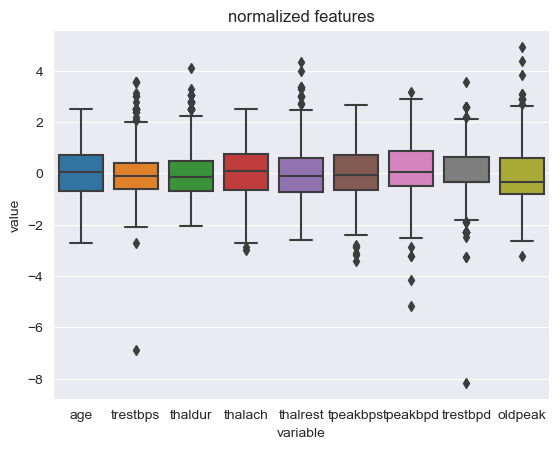

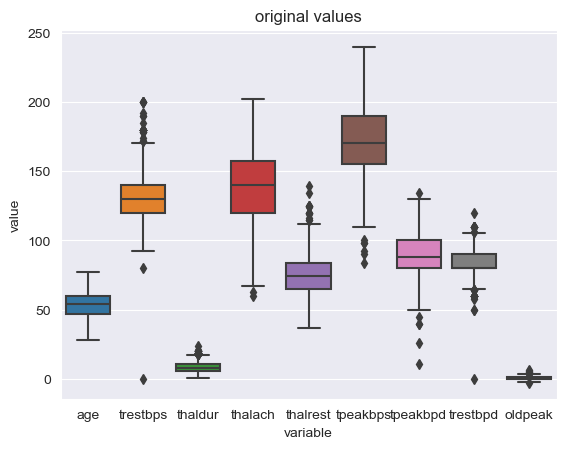

In [17]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]

sc = StandardScaler()
temp = sc.fit_transform(df_continous)
df_continous = pd.DataFrame(temp, columns = ["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"])
sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("normalized features")
plt.show()

df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]

sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("original values")
plt.show()




## Correlation

In [18]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
test = {}
for percentage in np.arange(0,100,1):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).shape + (df.drop([*missing_vlaues.keys()], axis=1).isna().sum().sum(), )

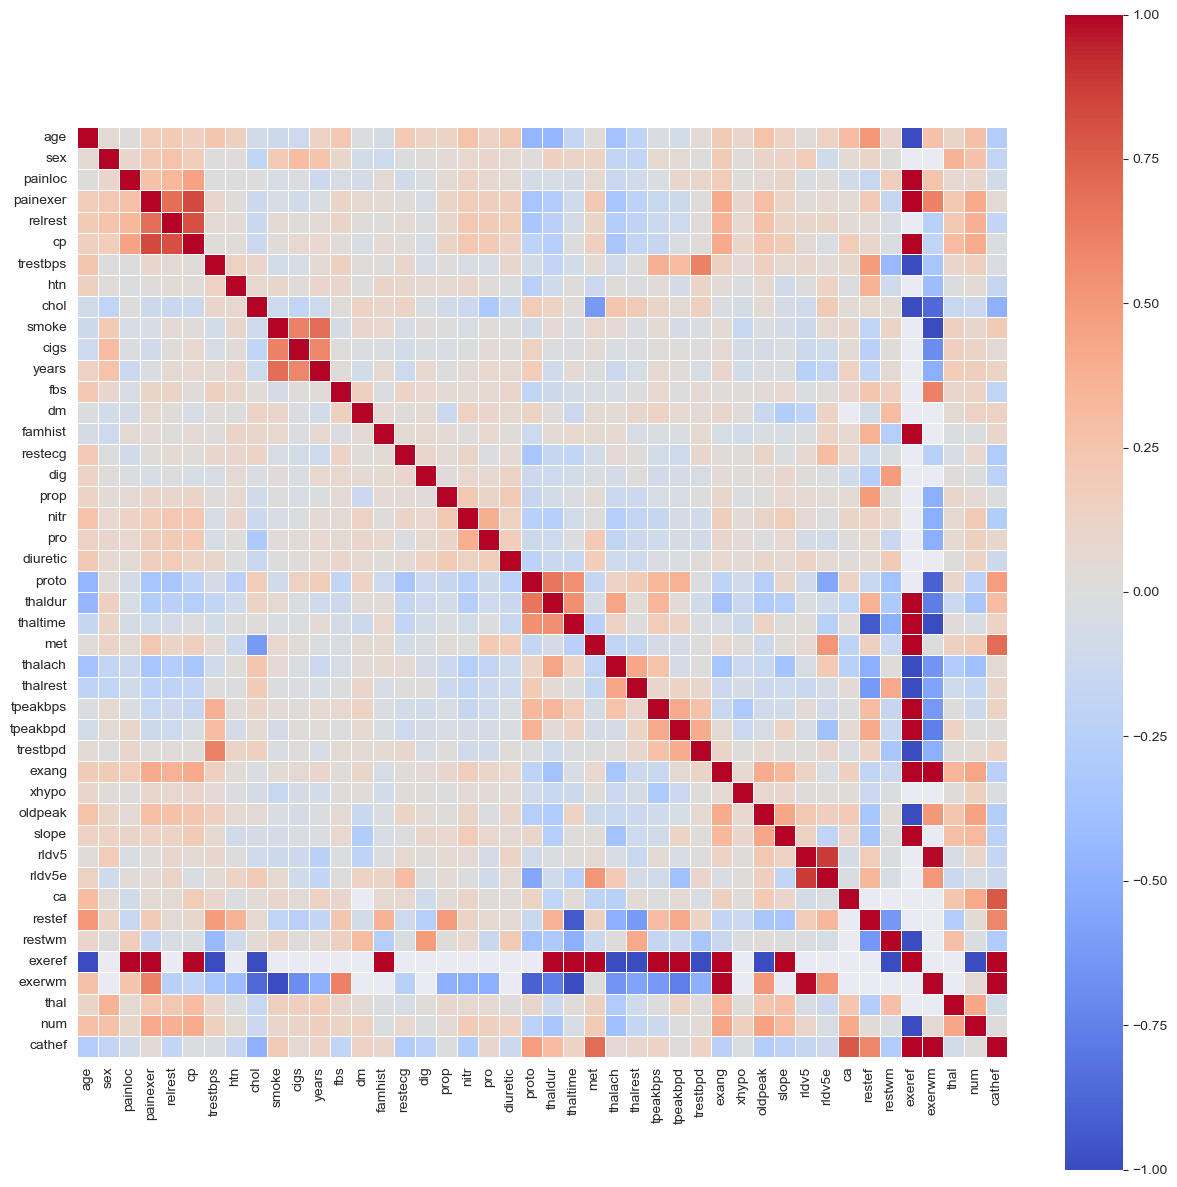

In [19]:
plt.figure(figsize=(15,15))
# Compute the correlation matrix
corr = df.corr()
corr = corr.round(2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

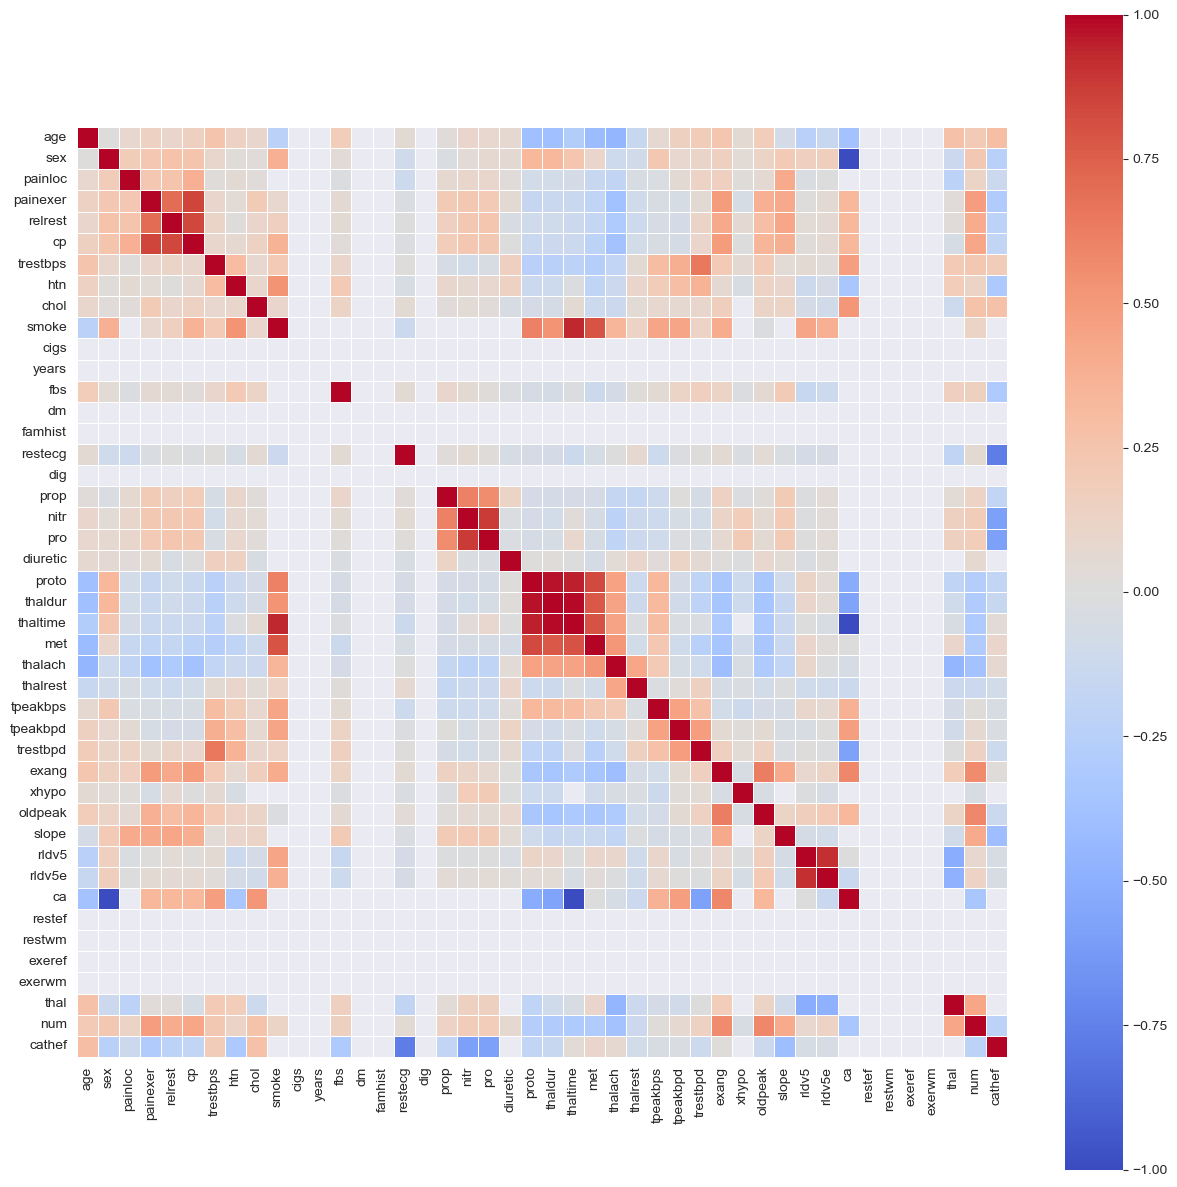

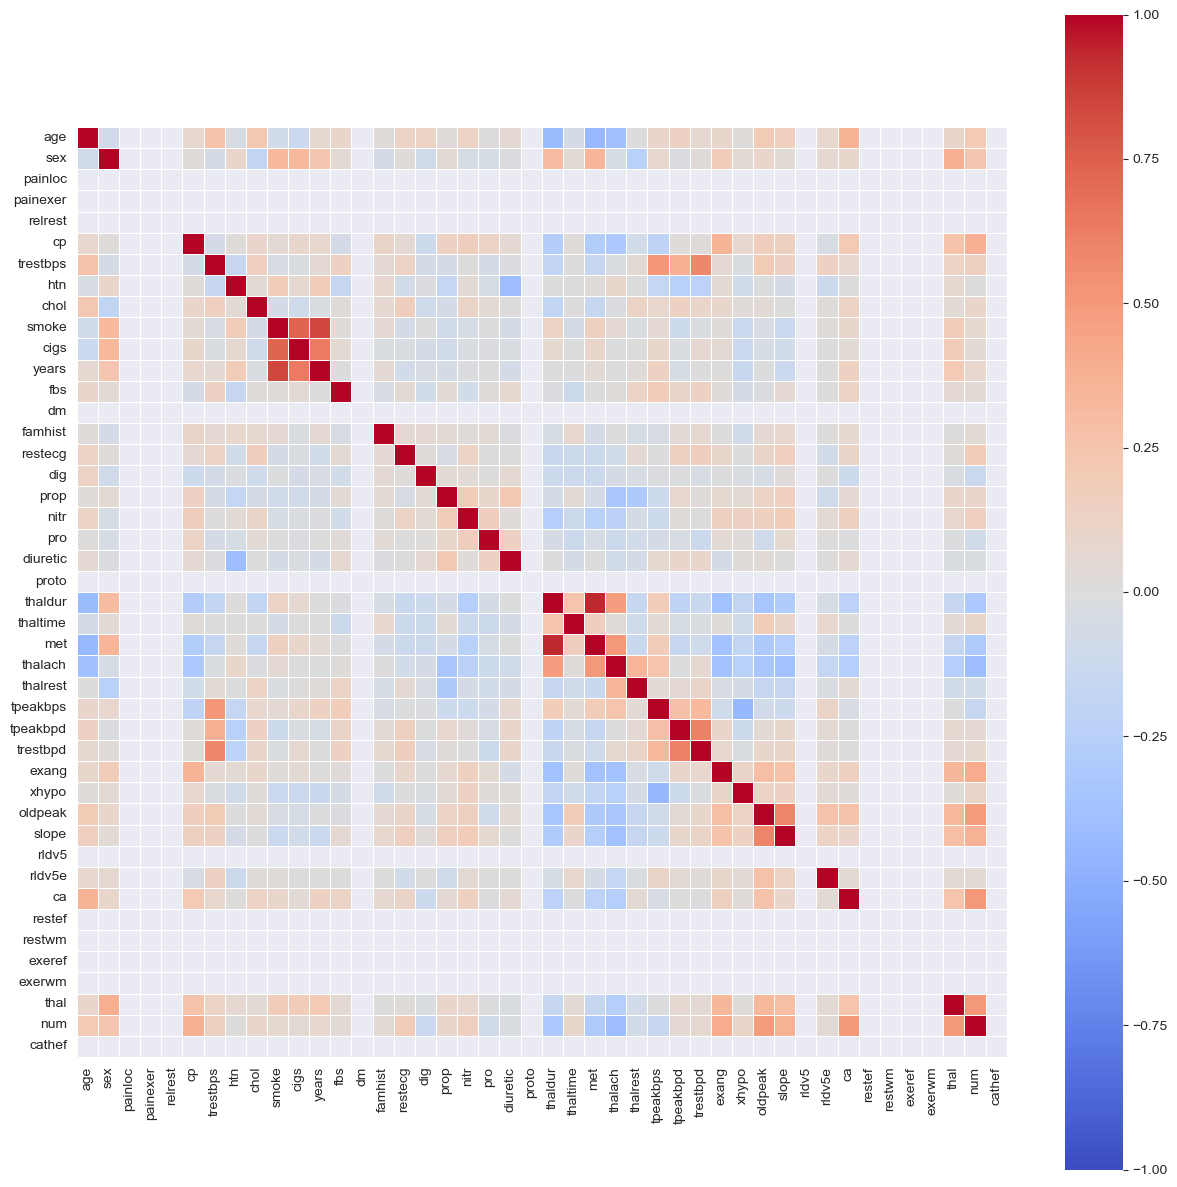

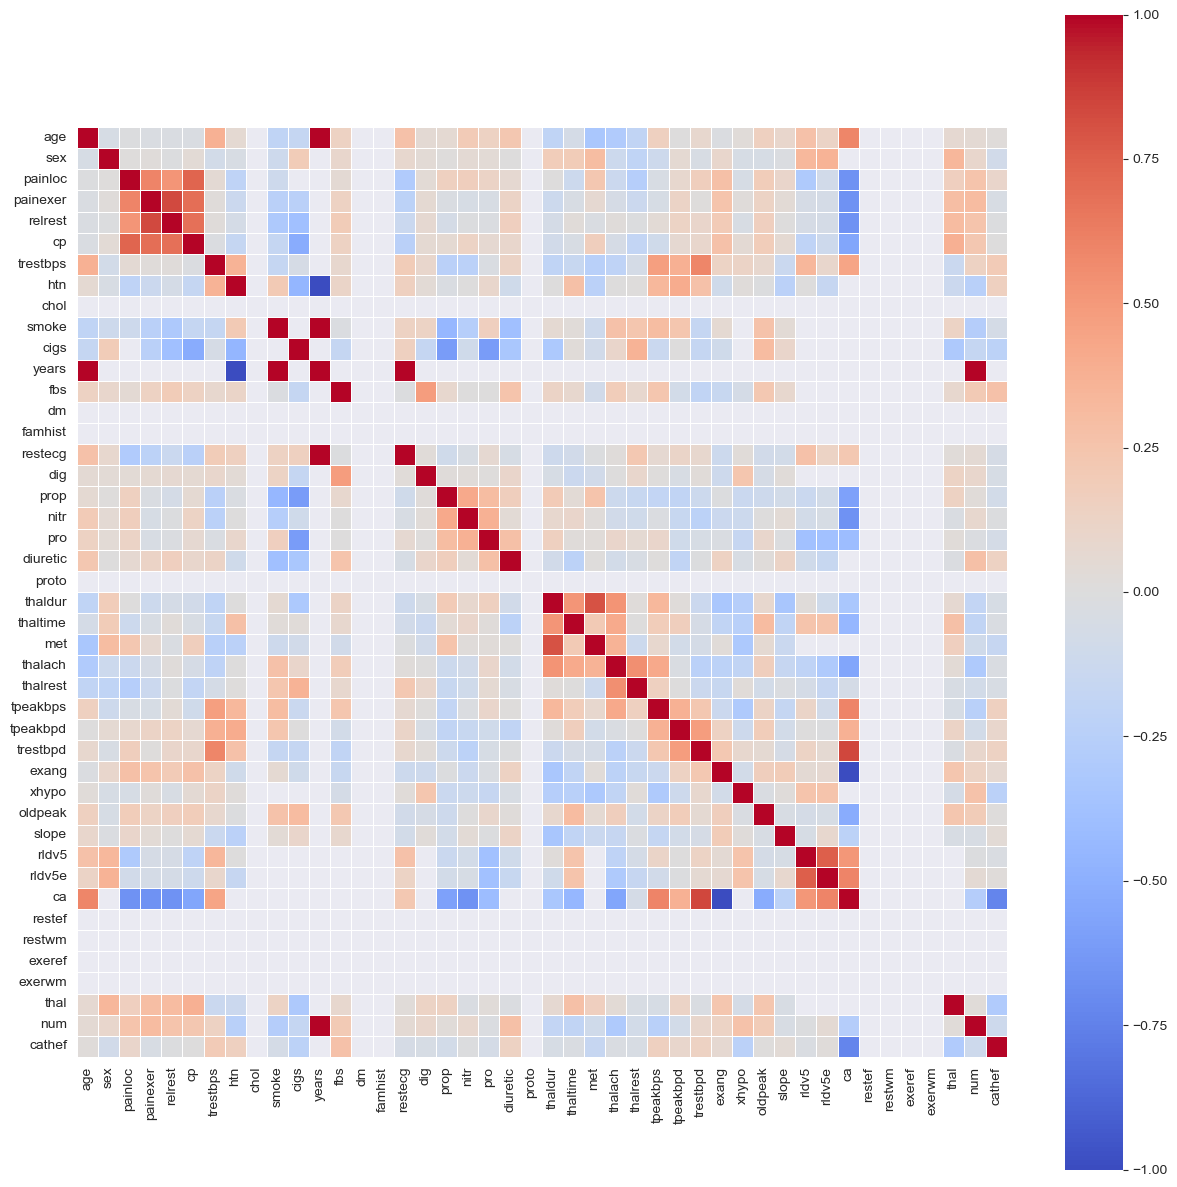

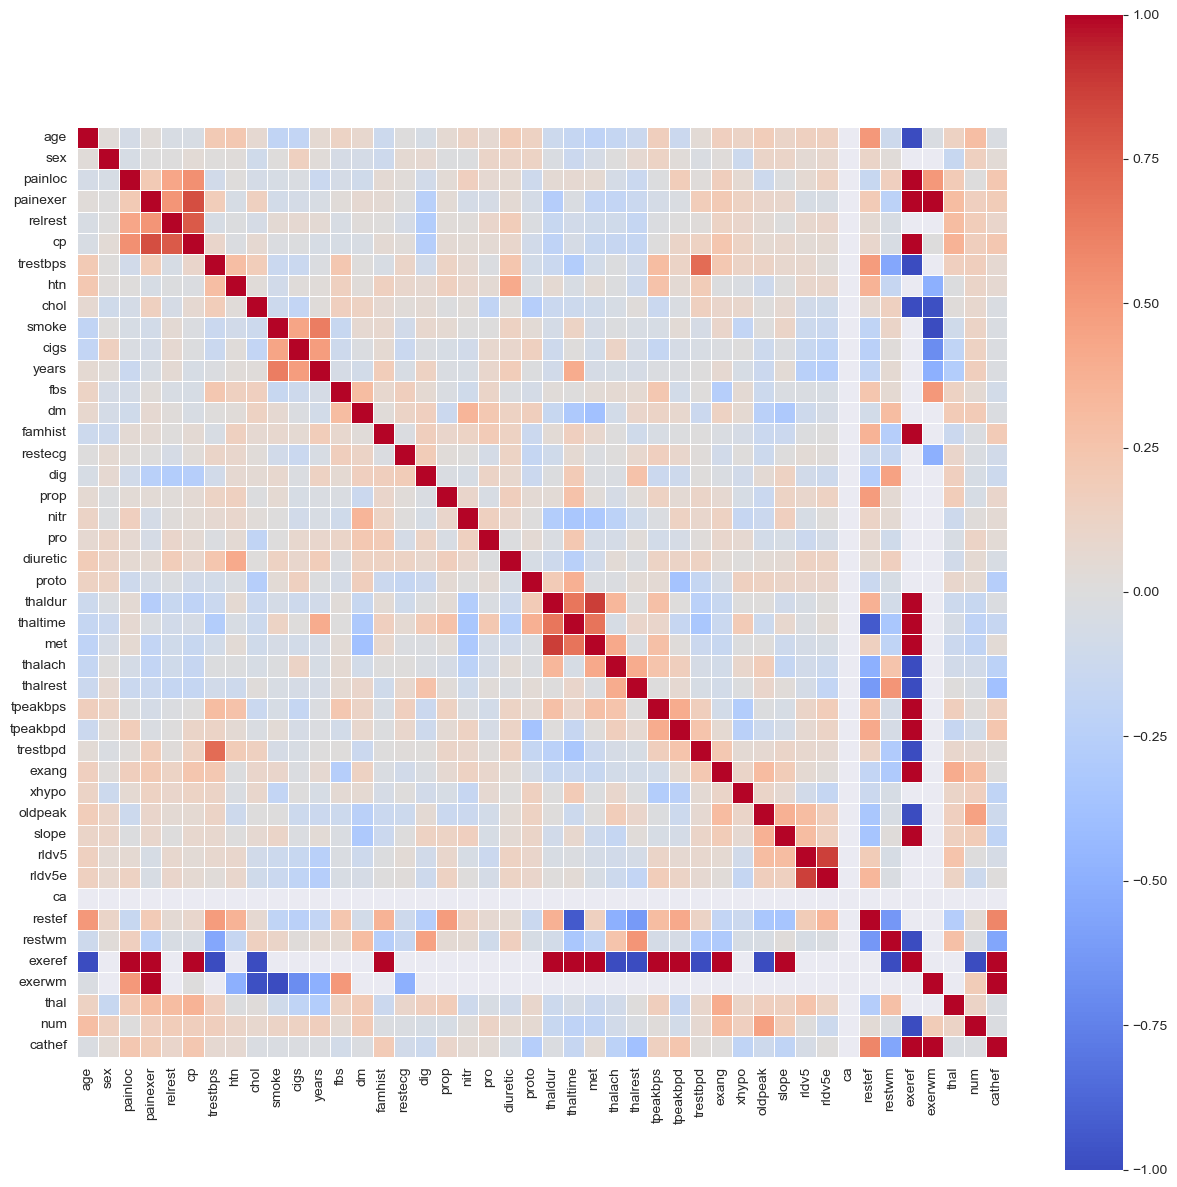

In [20]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    # Compute the correlation matrix
    corr = df[df['dataset'] == dataset].corr()
    corr = corr.round(2)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
    plt.show()


In [26]:
df_corr = df.copy()
df_corr = pd.concat([df_corr,pd.get_dummies(df_corr['cp'], prefix='cp')],axis=1)
df_corr.drop(['cp'],axis=1, inplace=True)

percentage_missing = ((df_corr.isna().sum()/len(df_corr)*100).round(2)).to_dict()

In [34]:
unstacked_corr = df_corr.corr().unstack()
#remove duplicate pairs
#index = pd.MultiIndex.from_tuples(tuples)
unstacked_corr = unstacked_corr.reset_index()
unstacked_corr.columns = ["feature1","feature2","correlation"]
#remove duplicates and correlation between the same feature
unstacked_corr = unstacked_corr[unstacked_corr['feature1'] < unstacked_corr['feature2']]
unstacked_corr['NaN_Values_feature1'] = [percentage_missing[x] for x in unstacked_corr['feature1']]
unstacked_corr['NaN_Values_feature2'] = [percentage_missing[x] for x in unstacked_corr['feature2']]
unstacked_corr['abs_corr'] = abs(unstacked_corr['correlation'])
unstacked_corr = unstacked_corr[(abs(unstacked_corr["correlation"]) > 0.5) & (unstacked_corr['NaN_Values_feature1'] < 75) & (unstacked_corr['NaN_Values_feature2'] < 75)].sort_values(by="abs_corr", ascending=False)
unstacked_corr.drop(["abs_corr"], inplace=True, axis=1)
print(unstacked_corr)

      feature1  feature2  correlation  NaN_Values_feature1  \
2165      cp_4  painexer     0.927771                 0.00   
1585     rldv5    rldv5e     0.884520                47.27   
1687        ca    cathef     0.784472                67.63   
2166      cp_4   relrest     0.719787                 0.00   
2072      cp_2   relrest    -0.712302                 0.00   
386      smoke     years     0.704192                43.05   
1997    cathef       met     0.696134                65.41   
145   painexer   relrest     0.694375                31.37   
961      proto   thaldur     0.663422                12.46   
2023      cp_1   painloc    -0.638315                 0.00   
352       chol       met    -0.619028                 3.34   
1321  trestbpd  trestbps     0.614386                 6.56   
431       cigs     smoke     0.610471                46.72   
433       cigs     years     0.589092                46.72   
2161      cp_3      cp_4    -0.582680                 0.00   
1009   t

In [37]:
cp_4VSpainexer = pd.crosstab(df_corr['cp_4'], df_corr['painexer'], rownames=['cp_4'], colnames=['painexer'])
cpVSpainexer = pd.crosstab(df['cp'], df['painexer'], rownames=['cp_4'], colnames=['painexer'])
print(cp_4VSpainexer)
print("------------------------------------")
print(cpVSpainexer)

painexer  0.0  1.0
cp_4              
0         247   18
1           4  348
------------------------------------
painexer  0.0  1.0
cp_4              
1          22    1
2         117    7
3         108   10
4           4  348


## PairPlots

# minimumPercentageToBeDropped

In [174]:
print_pair_plots = False #was missing
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [175]:
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns", "number of imputed cells"]

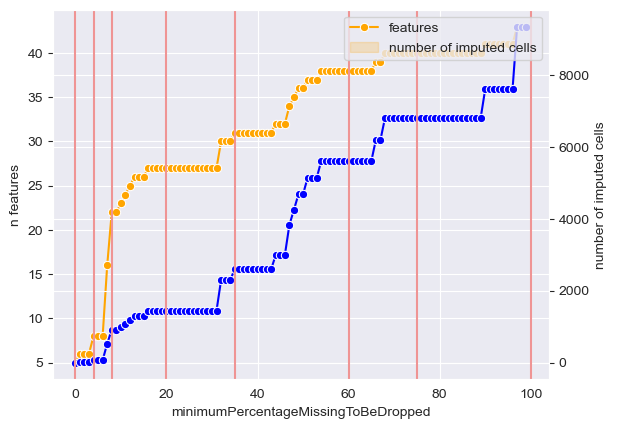

In [190]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="number of imputed cells", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('number of imputed cells')
ax1.figure.legend(['features','number of imputed cells'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)

#add decided thresholds
thresholds = [0,4,8,20,35,60,75,100]
for threshold in thresholds:
    plt.axvline(threshold,color="#ef9494")


plt.show()

In [242]:
percentage_missing = ((df.isna().sum() / len(df) * 100).round(2)).to_dict()
test = {}
for percentage in np.arange(0, 100, 10):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).dropna(axis=0, how='any').shape
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns"]

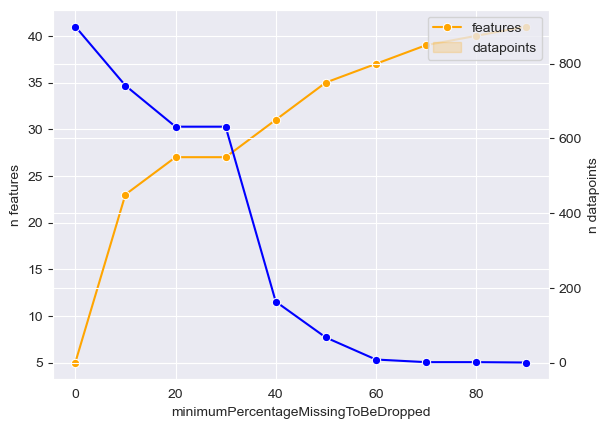

In [243]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="rows", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('n datapoints')
ax1.figure.legend(['features','datapoints'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)
plt.show()